# Happywhale - CS795 Project 1
***
Old Dominion University

2/26/2022
#### Authors: Raphael J. Sandor, Xiangrui Xu


# Setup

## Imports

In [1]:
import efficientnet.tfkeras as efn
import glob
import json
import keras
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import pickle
import pathlib
import seaborn as sns
import warnings
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as tfhub
import random
import re
from scipy import stats
from scipy.stats import norm
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from PIL import Image
from pathlib import Path
from datetime import datetime
from keras.optimizers import adam_v2
from tensorflow.keras import backend as K
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
warnings.filterwarnings('ignore')
%matplotlib inline

2022-03-19 17:49:04.222094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:49:04.310021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:49:04.310175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Global Data

In [2]:
train_df = pd.read_csv('train.csv')

'''
    Use sample submission to gather which 
    images need predictions made 
'''
test_df = pd.read_csv('sample_submission.csv')

total_image_df =  pd.concat([train_df['image'], test_df['image']])
TRAIN_IMAGES_DIR = Path("./train_images")
TEST_IMAGES_DIR = Path("./test_images")
train_images = list(TRAIN_IMAGES_DIR.glob('./*'))

# Exploritory Data Analysis

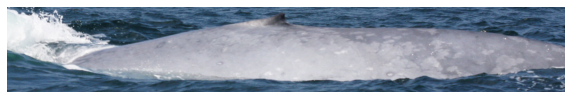

In [3]:
img = PIL.Image.open(str(train_images[1000]))
plt.figure(figsize = (10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
trainImgCnt = len(list(TRAIN_IMAGES_DIR.glob('*.jpg')))
testImgCnt = len(list(TEST_IMAGES_DIR.glob('*.jpg')))

In [5]:
print("Train image count: " + str(trainImgCnt))
print("Test image count: " + str(testImgCnt))

Train image count: 51033
Test image count: 27956


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51033 entries, 0 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          51033 non-null  object
 1   species        51033 non-null  object
 2   individual_id  51033 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [7]:
# Data in train
train_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


## Unique Species 

In [8]:
species = train_df['species']

In [9]:
train_df.describe()

# Used to create tables in latex
# with open('mytable.tex', 'w') as tf:
#      tf.write(train_df.describe().to_latex())

,image,species,individual_id
count,51033,51033,51033
unique,51033,30,15587
top,00021adfb725ed.jpg,bottlenose_dolphin,37c7aba965a5
freq,1,9664,400


In [10]:
unique_species = pd.unique(species) # returns numpy.ndarray 
print("Unique Species")
print("-------------------")
print(*unique_species, sep='\n')

Unique Species
-------------------
melon_headed_whale
humpback_whale
false_killer_whale
bottlenose_dolphin
beluga
minke_whale
fin_whale
blue_whale
gray_whale
southern_right_whale
common_dolphin
kiler_whale
pilot_whale
dusky_dolphin
killer_whale
long_finned_pilot_whale
sei_whale
spinner_dolphin
bottlenose_dolpin
cuviers_beaked_whale
spotted_dolphin
globis
brydes_whale
commersons_dolphin
white_sided_dolphin
short_finned_pilot_whale
rough_toothed_dolphin
pantropic_spotted_dolphin
pygmy_killer_whale
frasiers_dolphin


## Whales and Dolphins

In [11]:
# Note that the dataset includes some typo mistakes mistakes.
train_df['species'].replace('bottlenose_dolpin', 'bottlenose_dolphin', inplace=True)
train_df['species'].replace('kiler_whale', 'killer_whale', inplace=True)
train_df['species'][(train_df['species'] =="pilot_whale") 
            | (train_df['species'] =="globis" )]='short_finned_pilot_whale'

whales = ['humpback_whale','beluga','minke_whale', 
          'fin_whale', 'blue_whale', 'gray_whale',
          'southern_right_whale','sei_whale', 
          'cuviers_beaked_whale', 'brydes_whale']

dolphins = ['melon_headed_whale','false_killer_whale',
            'bottlenose_dolphin', 'common_dolphin', 
            'dusky_dolphin', 'killer_whale', 
            'long_finned_pilot_whale', 'spinner_dolphin', 
            'spotted_dolphin','commersons_dolphin', 
            'white_sided_dolphin', 'short_finned_pilot_whale',
            'rough_toothed_dolphin', 'pantropic_spotted_dolphin', 
            'frasiers_dolphin', 'pygmy_killer_whale']

In [12]:
whale_df = train_df[train_df['species'].str.contains('|'.join(whales))]
dolphin_df = train_df[train_df['species'].str.contains('|'.join(dolphins))]
print("Total species after :",len(train_df.species.unique()))

Total species after : 26


In [13]:
print(whale_df.head())
print("---------------------------------------------")
print(dolphin_df.head())

                image         species individual_id
1  000562241d384d.jpg  humpback_whale  1a71fbb72250
4  00087baf5cef7a.jpg  humpback_whale  8e5253662392
6  000be9acf46619.jpg          beluga  afb9b3978217
7  000bef247c7a42.jpg  humpback_whale  444d8894ccc8
8  000c3d63069748.jpg          beluga  df94b15285b9
---------------------------------------------
                image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
5  000a8f2d5c316a.jpg  bottlenose_dolphin  b9907151f66e
9  000c476c11bad5.jpg  bottlenose_dolphin  b11b2404c7e3


In [14]:
if not os.path.exists("figures"):
    os.makedirs("figures")  # Directory to save figures

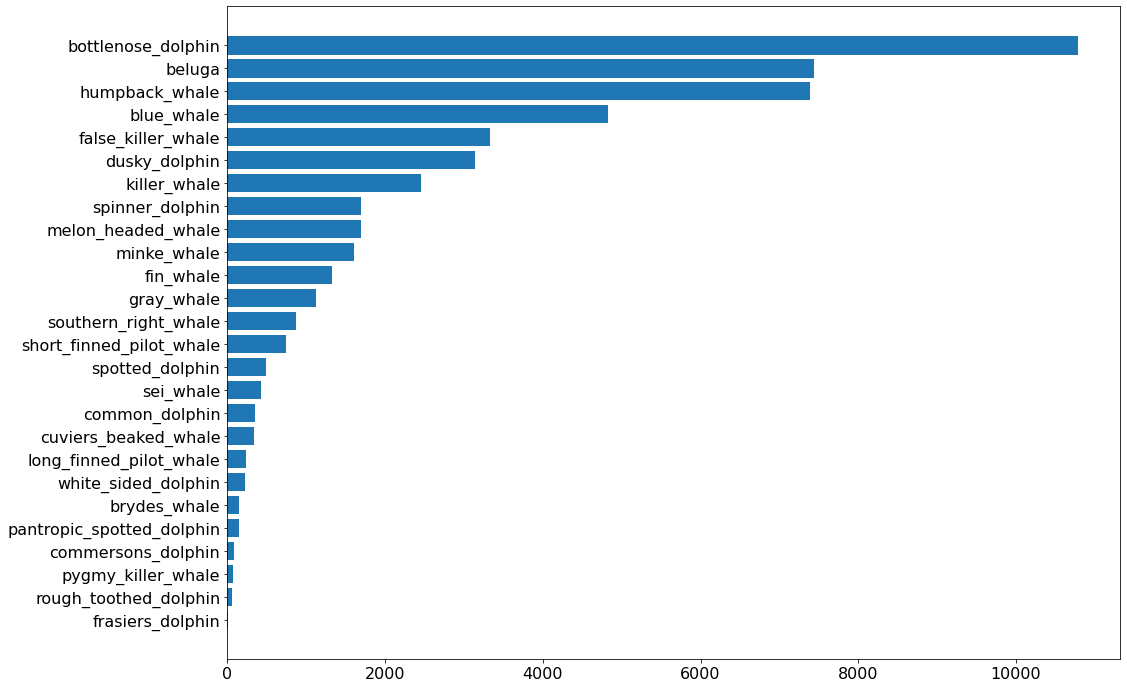

In [15]:
## lets check speiceis in visually
# Nikhil Jothi Prakash 
# Works cited: https://www.kaggle.com/nikhiljothiprakash/happy-whale-and-dolphin
plt.figure(figsize=(16, 12))
plt.rcParams["font.size"] = 16
plt.barh(train_df["species"].value_counts().sort_values(ascending=True).index,train_df["species"].value_counts().sort_values(ascending=True),tick_label = train_df["species"].value_counts().sort_values(ascending=True).index)
#plt.savefig('./figures/species.png', bbox_inches='tight')
plt.show()

In [16]:
print("Species of whales: " + str(len(whales)))
print("Species of dolphins: " + str(len(dolphins)))

Species of whales: 10
Species of dolphins: 16


In [17]:
print("Number of whales: " + str(whale_df.shape[0]))
print("Number of dolphins: " + str(dolphin_df.shape[0]))

Number of whales: 25509
Number of dolphins: 25524


In [18]:
# now lets classify on whales.
train_df['isWhale'] = train_df.species.isin(whale_df.species).astype(int)
train_data = []

In [19]:
train_df.describe()

,isWhale
count,51033.000000
mean,0.499853
std,0.500005
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [20]:
# Borrowed from 
# https://www.kaggle.com/samir95/species-classification
_, dev, _ , _ = train_test_split(train_df, train_df['isWhale'], test_size=0.1)

dev.shape

(5104, 4)

In [21]:
dev['imagePath'] = dev['image'].apply(lambda f: TRAIN_IMAGES_DIR/f)
train_df['imagePath'] = train_df['image'].apply(lambda f: TRAIN_IMAGES_DIR/f)
test_df['imagePath'] = train_df['image'].apply(lambda f: TRAIN_IMAGES_DIR/f)

# Part 1.

# Convolutional Neural Network Dataset
<ol>
  <li>Load the data.</li>
  <li>Resize images to be normalized</li>
</ol>
<i> If I had more time and knowledge I would use the TFRecords from the next step </i>

In [22]:
# Referenced for using cnn and fastai: https://www.kaggle.com/samir95/species-classification/notebook
import fastai
from fastai.vision.all import *
from fastai.basics import *
from fastai.data.all import *

from fastai.vision.core import *
import fastbook
fastbook.setup_book() 
pd.options.mode.chained_assignment = None  # default='warn'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_x=ColReader('imagePath'),
                   get_y=lambda r: r['isWhale'],
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224))
#dblock.summary(dev)
dsets = dblock.datasets(dev)
dls = dblock.dataloaders(dev)

## Start Convolution Neural Network Learning

SuggestedLRs(valley=0.0008317637839354575)

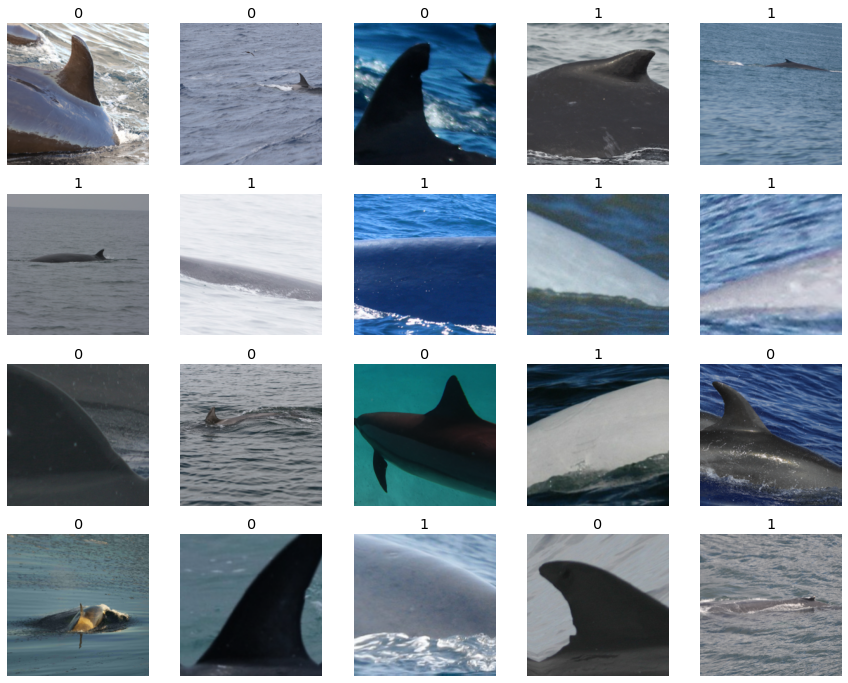

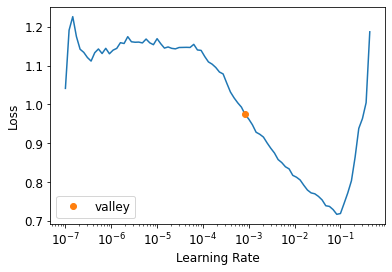

In [23]:
dls.show_batch(max_n=20)
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.lr_find()

              precision    recall  f1-score   support

           0       0.51      0.59      0.55       499
           1       0.54      0.46      0.50       521

    accuracy                           0.53      1020
   macro avg       0.53      0.53      0.52      1020
weighted avg       0.53      0.53      0.52      1020



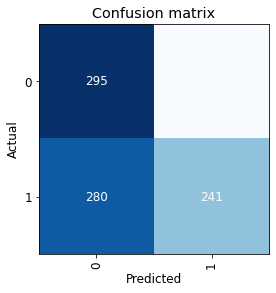

In [24]:
# Initial performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

## Fine Tune and Improve

In [25]:
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.449195,0.166258,0.949020,0.050980,01:32


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.227850,0.100897,0.963726,0.036275,01:33
1,0.130124,0.061610,0.980392,0.019608,01:33


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       499
           1       0.98      0.98      0.98       521

    accuracy                           0.98      1020
   macro avg       0.98      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020



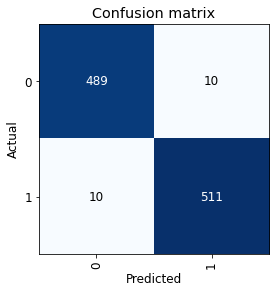

In [26]:
# Checkpoint performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

In [27]:
learn.save('./models')
learn.freeze()
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.111078,0.093615,0.961765,0.038235,01:31
1,0.108276,0.063537,0.973529,0.026471,01:31
2,0.077443,0.066679,0.973529,0.026471,01:30


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       499
           1       0.99      0.96      0.97       521

    accuracy                           0.97      1020
   macro avg       0.97      0.97      0.97      1020
weighted avg       0.97      0.97      0.97      1020



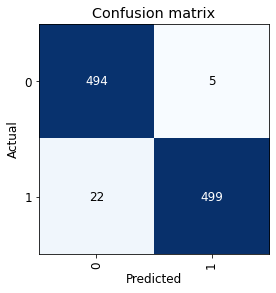

In [28]:
# Checkpoint2 performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

SuggestedLRs(valley=9.12010818865383e-07)

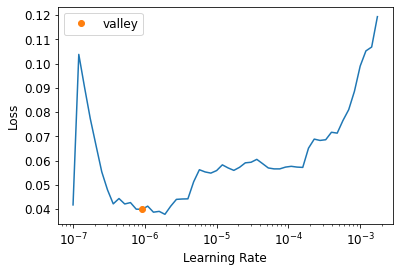

In [29]:
learn.unfreeze()
learn.lr_find()

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       499
           1       0.99      0.96      0.97       521

    accuracy                           0.97      1020
   macro avg       0.97      0.97      0.97      1020
weighted avg       0.97      0.97      0.97      1020



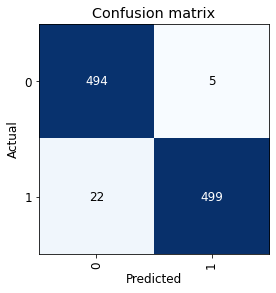

In [30]:
# Checkpoint3 performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

In [31]:
learn.fit_one_cycle(6, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.061323,0.061429,0.979412,0.020588,01:32
1,0.063704,0.058707,0.977451,0.022549,01:34
2,0.051619,0.054067,0.980392,0.019608,01:32
3,0.045816,0.062616,0.978431,0.021569,01:33
4,0.042287,0.053891,0.979412,0.020588,01:31
5,0.043474,0.053070,0.979412,0.020588,01:32


## Performance Metrics (precision, recall, and accuracy)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       499
           1       0.98      0.98      0.98       521

    accuracy                           0.98      1020
   macro avg       0.98      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020



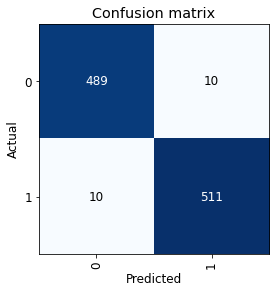

In [32]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.load('./models')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

# Part 2.

# Individual Classification
Research based on https://www.kaggle.com/nikhiljothiprakash/happy-whale-and-dolphin


## TFRecords For Faster Performance 
##### Creating TFRecords will provide better performance than manual image manipulations according to Keras.
https://keras.io/examples/keras_recipes/creating_tfrecords/

<i> We'll use this when we do individual predicitions <i>

### Setup Data

In [33]:
# Works cited:
# https://www.kaggle.com/nikhiljothiprakash/happy-whale-and-dolphin/notebook
concat_df = pd.concat([train_df['image'], test_df['image']])

### Dictionaries

In [34]:
## lets create dict for species
spid_dict = dict((a,b) for b,a in enumerate(train_df.species.unique()))
spid_dict_inverse={(c,d) for d,c in spid_dict.items()}
print(spid_dict)

{'melon_headed_whale': 0, 'humpback_whale': 1, 'false_killer_whale': 2, 'bottlenose_dolphin': 3, 'beluga': 4, 'minke_whale': 5, 'fin_whale': 6, 'blue_whale': 7, 'gray_whale': 8, 'southern_right_whale': 9, 'common_dolphin': 10, 'killer_whale': 11, 'short_finned_pilot_whale': 12, 'dusky_dolphin': 13, 'long_finned_pilot_whale': 14, 'sei_whale': 15, 'spinner_dolphin': 16, 'cuviers_beaked_whale': 17, 'spotted_dolphin': 18, 'brydes_whale': 19, 'commersons_dolphin': 20, 'white_sided_dolphin': 21, 'rough_toothed_dolphin': 22, 'pantropic_spotted_dolphin': 23, 'pygmy_killer_whale': 24, 'frasiers_dolphin': 25}


In [24]:
train_df["species"] = [spid_dict[i] for i in train_df.species]

In [25]:
image_name_to_image_id = dict((image_name, index) for index, image_name in enumerate(concat_df.unique()))

In [26]:
img_dict = dict((image,index) for index,image in enumerate(concat_df.unique()))
img_dict_inverse = {ind:img for img,ind in img_dict.items()}

In [27]:
## lets create dict for individual id 
id_dict = dict((a,b) for b,a in enumerate(train_df.individual_id.unique()))
id_dict_inverse={(c,d) for d,c in id_dict.items()}

In [28]:
# Label is which id the image id's belong to, its easier to work with than the indvidual id.
train_df["label"]=[id_dict[i] for i in train_df.individual_id]
train_df["image_id"]=[img_dict[i] for i in train_df['image']]
train_df.head(20)

,image,species,individual_id,isWhale,imagePath,label,image_id
0,00021adfb725ed.jpg,0,cadddb1636b9,0,train_images/00021adfb725ed.jpg,0,0
1,000562241d384d.jpg,1,1a71fbb72250,1,train_images/000562241d384d.jpg,1,1
2,0007c33415ce37.jpg,2,60008f293a2b,0,train_images/0007c33415ce37.jpg,2,2
3,0007d9bca26a99.jpg,3,4b00fe572063,0,train_images/0007d9bca26a99.jpg,3,3
4,00087baf5cef7a.jpg,1,8e5253662392,1,train_images/00087baf5cef7a.jpg,4,4
5,000a8f2d5c316a.jpg,3,b9907151f66e,0,train_images/000a8f2d5c316a.jpg,5,5
6,000be9acf46619.jpg,4,afb9b3978217,1,train_images/000be9acf46619.jpg,6,6
7,000bef247c7a42.jpg,1,444d8894ccc8,1,train_images/000bef247c7a42.jpg,7,7
8,000c3d63069748.jpg,4,df94b15285b9,1,train_images/000c3d63069748.jpg,8,8
9,000c476c11bad5.jpg,3,b11b2404c7e3,0,train_images/000c476c11bad5.jpg,9,9


### Helper TFRecords Functions
Borrowed from Keras:https://keras.io/examples/keras_recipes/creating_tfrecords/

In [29]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [30]:
tfrecords_dir = "tfrecords"
num_samples = 4096

train_tfrecords = trainImgCnt // num_samples
test_tfrecords = testImgCnt // num_samples

print("Train TFRecords: " + str(train_tfrecords))
print("Test TFRecords: " + str(test_tfrecords))

Train TFRecords: 12
Test TFRecords: 6


In [31]:
if train_tfrecords % num_samples:
    train_tfrecords += 1  # add one record if there are any remaining samples
    
if test_tfrecords % num_samples:
    test_tfrecords += 1  # add one record if there are any remaining samples

### Create TFRecords
Faster image manipulation in the future.

In [32]:
if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder
    
if not os.path.exists(tfrecords_dir + "/train"):
    os.makedirs(tfrecords_dir + "/train")  # creating TFRecords output folder    
    
if not os.path.exists(tfrecords_dir + "/test"):
    os.makedirs(tfrecords_dir + "/test")  # creating TFRecords output folder    

In [33]:
''' 
    Borrowed example of making records from:
    Gaurav Chopra
    https://www.kaggle.com/gauravchopracg/understanding-tfrecord-format

    And https://keras.io/examples/keras_recipes/creating_tfrecords/
'''
#Create a function to apply entire process to each element of dataset.
# process the two images into 'tf.Example' messages. 
def create_example(image_name, image, species, label):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
   # "image_id": tf.io.FixedLenFeature([], tf.string),
   #      "image": tf.io.FixedLenFeature([], tf.string),
   #      "label": tf.io.FixedLenFeature([], tf.int64),f
  feature = {
    "image_name": bytes_feature(str(image_name)),
    "image": image_feature(image),
    "species": int64_feature(species),
    "target": int64_feature(label)
  }  
  # Create a Features message using tf.train.Example.
  return tf.train.Example(features=tf.train.Features(feature=feature))

def  write_records(outputDir, dataframe, rec_num, num_samples, prefix):
    for tfrec_num in range(rec_num):
      samples = dataframe.iloc[(tfrec_num * num_samples):((tfrec_num + 1) * num_samples),:]  
      print("%s record %s already exists? " % (prefix, tfrec_num) + str(os.path.exists(outputDir + "/%s_%.2i-%i.tfrec" % (prefix, tfrec_num, len(samples)))))
      if not os.path.exists(outputDir + "/%s_%.2i-%i.tfrec" % (prefix, tfrec_num, len(samples))):
        print("Making record: "+ str(tfrec_num))
        with tf.io.TFRecordWriter(
          outputDir + "/%s_%.2i-%i.tfrec" %(prefix, tfrec_num, len(samples))
        ) as writer:
              for i, sample in samples.iterrows():
                image = tf.io.decode_jpeg(tf.io.read_file(str(sample['imagePath'])))
                if prefix == "train":
                  tf_example = create_example(sample['image'], image, sample['species'], sample['label'])
                else:
                  tf_example = create_example(sample['image'], image, -1, -1)
                writer.write(tf_example.SerializeToString())

In [34]:
# define a filename to store preprocessed image data:
train_tfrecords_dir = 'tfrecords/train'
test_tfrecord_dir = 'tfrecords/test'
train_temp = train_df[['image','imagePath', 'species', 'label']].copy()
# The first is really the image name, the second is the path to the image
test_temp = test_df[['image','imagePath']].copy()

In [35]:
write_records(train_tfrecords_dir, train_temp, train_tfrecords, num_samples, "train")
write_records(test_tfrecord_dir, test_temp, test_tfrecords, num_samples, "test")

train record 0 already exists? True
train record 1 already exists? True
train record 2 already exists? True
train record 3 already exists? True
train record 4 already exists? True
train record 5 already exists? True
train record 6 already exists? True
train record 7 already exists? True
train record 8 already exists? True
train record 9 already exists? True
train record 10 already exists? True
train record 11 already exists? True
train record 12 already exists? True
test record 0 already exists? True
test record 1 already exists? True
test record 2 already exists? True
test record 3 already exists? True
test record 4 already exists? True
test record 5 already exists? True
test record 6 already exists? True


In [36]:
from sklearn import model_selection

In [38]:
def create_folds(data,target,num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data[target], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

In [39]:
save_dir = '.'
EXPERIMENT = 0
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)

20220319-103052


## Model Configuration Settings

In [40]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
os.environ["TF_GPU_ALLOCATOR"] ="cuda_malloc_async" # reclaim GPU memory.

class config:    
    
    SEED = 42
    FOLD_TO_RUN = 0
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync #Note I had to change this to run locally because it took too much memory. Should be 32
    IMAGE_SIZE = 128 # Changed for memory constraints should 512
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 5
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 20
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 50
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO
True


2022-03-19 10:30:54.056421: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-19 10:30:54.056924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 10:30:54.057201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 10:30:54.057366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [41]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b5


In [42]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [43]:
train_files = np.sort(np.array(tf.io.gfile.glob('./tfrecords/train/*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob('./tfrecords/test/*.tfrec')))
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

13 7 51033 27956


In [46]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = tf.data.AUTOTUNE)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = tf.data.AUTOTUNE) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(arcface_format, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(arcface_format, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = tf.data.AUTOTUNE)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = tf.data.AUTOTUNE)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

51033


In [47]:
for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

2022-03-19 10:32:42.104586: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56975769 exceeds 10% of free system memory.


<Figure size 1800x0 with 0 Axes>

In [48]:
print(img.shape)

(4, 128, 128, 3)


In [49]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [50]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp) # weight originally noisy-student
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

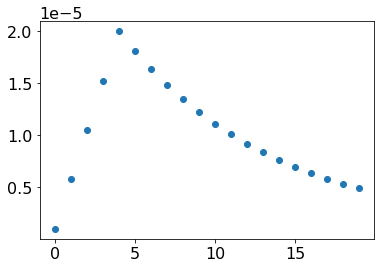

In [51]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [52]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

In [53]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

10 3 38745 12288


In [54]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [55]:
seed_everything(config.SEED)
VERBOSE = 1
trrchgin_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE

train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)

# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')

# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b5 (Functional)   (None, None, None,   28513520    ['inp1[0][0]']                   
                                2048)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['efficientnet-b5[0][0]']        
 alAveragePooling2D)                                                                          

## Training the Model

In [56]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)

#### Image Size 128 with EfficientNet B5 and batch_size 4
Epoch 1/20


2022-03-19 10:33:38.628601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-19 10:33:41.227561: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-03-19 10:33:41.391599: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-19 10:33:41.391641: W tensorflow/core

2172/9686 [=====>........................] - ETA: 13:16 - loss: 19.2612 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00

2022-03-19 10:37:32.797807: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56905200 exceeds 10% of free system memory.


2835/9686 [=======>......................] - ETA: 12:14 - loss: 19.2358 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00

2022-03-19 10:38:46.810370: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50317200 exceeds 10% of free system memory.


2896/9686 [=======>......................] - ETA: 12:07 - loss: 19.2311 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00

2022-03-19 10:38:53.079493: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50317200 exceeds 10% of free system memory.


3258/9686 [=========>....................] - ETA: 11:27 - loss: 19.2161 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00

2022-03-19 10:39:30.930368: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56905200 exceeds 10% of free system memory.


9686/9686 [==============================] - 1165s 116ms/step - loss: 18.9730 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.9939 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/20
9686/9686 [==============================] - 1124s 116ms/step - loss: 17.8776 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.1791 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 5.7500e-06
Epoch 3/20
9686/9686 [==============================] - 1157s 119ms/step - loss: 17.1828 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 17.3813 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0500e-05
Epoch 4/20
9686/9686 [==============================] - 1146s 118ms/s

In [57]:
model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss.h5")

In [58]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0


In [59]:
"""f = open ('../input/happywhale-splits/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}"""
target_encodings = id_dict
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [60]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/10 [00:00<?, ?it/s]

In [61]:
train_targets

array([  314,  2654,   241, ...,  8220, 13202,  1700], dtype=int32)

In [62]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=50)

In [63]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/3 [00:00<?, ?it/s]

In [64]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2696
37c7aba965a5        93
114207cab555        44
b9907151f66e        43
ce6e37904aa4        41
                  ... 
907572a53ac0         1
92a943baccfa         1
1135ff432965         1
2f0f12b245b3         1
557706d04aa8         1
Name: target, Length: 3602, dtype: int64

In [65]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/12288 [00:00<?, ?it/s]

50    1503
49    1192
48     925
47     792
46     698
45     678
44     580
43     553
36     437
35     428
34     425
42     409
41     407
40     394
37     392
38     384
39     382
33     332
32     274
31     230
30     141
29     116
28      81
27      56
26      48
6       35
17      31
7       29
24      29
25      26
18      24
10      23
21      23
23      20
20      20
8       20
19      18
16      18
9       17
22      15
13      13
2       11
11      10
15      10
12       9
14       9
5        9
4        9
3        3
Name: image, dtype: int64

In [66]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.0: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.1: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.2: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.4: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.5: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.8: 0.15534261067708324


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 0.9: 0.15538330078124993


0it [00:00, ?it/s]

  0%|          | 0/12288 [00:00<?, ?it/s]

CV at threshold 1.0: 0.24836018880208344


In [67]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 1.0
Best cv 0.24836018880208344


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
count,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000
mean,0.155343,0.155343,0.155343,0.155343,0.155343,0.155343,0.155343,0.155343,0.155343,0.155383,0.248360
std,0.259907,0.259907,0.259907,0.259907,0.259907,0.259907,0.259907,0.259907,0.259907,0.260000,0.411746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 9592, True: 2696}
best_threshold 1.0


is_new_individual,False,True,adjusted_cv
0.0,0.058471,0.500000,0.102624
0.1,0.058471,0.500000,0.102624
0.2,0.058471,0.500000,0.102624
0.30000000000000004,0.058471,0.500000,0.102624
0.4,0.058471,0.500000,0.102624
0.5,0.058471,0.500000,0.102624
0.6000000000000001,0.058471,0.500000,0.102624
0.7000000000000001,0.058471,0.500000,0.102624
0.8,0.058471,0.500000,0.102624
0.9,0.058471,0.500185,0.102642


In [69]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 512) (51033,)


In [70]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=50)

In [71]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/7 [00:00<?, ?it/s]

In [72]:
sample_submission = pd.read_csv('sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

50    3400
49    2650
48    2046
47    1732
46    1631
45    1464
44    1275
43    1149
42    1009
38     983
37     978
36     945
41     917
35     916
40     899
39     867
34     854
33     797
32     686
31     511
30     403
29     331
28     200
27     177
26     112
7       94
25      85
6       63
17      59
18      57
9       56
19      55
8       52
16      49
20      47
14      46
24      43
22      42
10      39
23      37
21      36
11      33
15      29
12      27
5       22
4       21
13      18
3        8
2        6
Name: image, dtype: int64

In [73]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

## Make Predicitions

In [74]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,8d0cb755b40f28.jpg,new_individual 4a67e64bd3b7 114207cab555 e6388...
1,0b7a095dc6504f.jpg,new_individual 2fdb3a09dc9c e5c22090279f b5e1e...
2,a2cb46ffae177c.jpg,new_individual add1cf013a01 c10397c3737e 9ebe2...
3,a2d1afafc625d3.jpg,new_individual 6f4abc5666cd beea17a19349 348f0...
4,a2d7696e9f0127.jpg,new_individual 39fdf5369ae2 e72dc305d994 180c0...


# Kaggle Score Score: 0.113